In [1]:
# Install TensorFlow package
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

#import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations

In [4]:
trainpath = r"C:\Users\Sakshi\Downloads\e-waste-generation-dataset\modified-dataset\train"
testpath = r"C:\Users\Sakshi\Downloads\e-waste-generation-dataset\modified-dataset\test"
validpath = r"C:\Users\Sakshi\Downloads\e-waste-generation-dataset\modified-dataset\val"

In [5]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [6]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [11]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [13]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


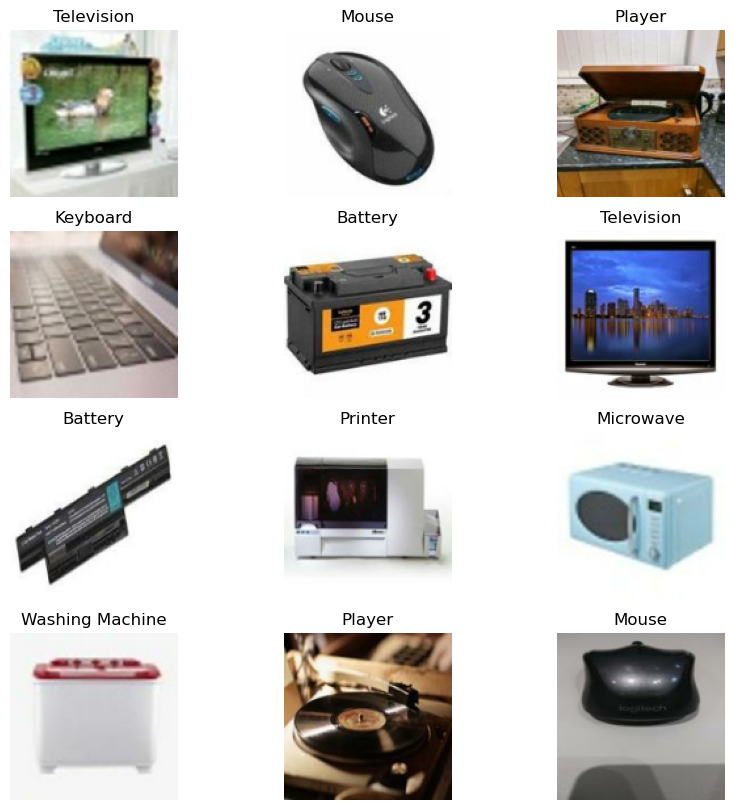

In [15]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

In [17]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class
    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot
# plot_class_distribution(datatrain, "Training Data Distribution")
# plot_class_distribution(datavalid, "Validation Data Distribution")
# plot_class_distribution(datatest, "Test Data Distribution")

In [19]:
import tensorflow as tf
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_dataset = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    image_size=(128, 128),
    batch_size=32,
    shuffle=True
)

validate_dataset = tf.keras.utils.image_dataset_from_directory(
    validpath,
    image_size=(128, 128),
    batch_size=32,
    shuffle=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    testpath,
    image_size=(128, 128),
    batch_size=32,
    shuffle=False
)
#normalize images
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    return preprocess_input(image), label

# Apply preprocessing
train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
validate_dataset = validate_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [21]:
# model selection
# use base model:custom cnn
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [23]:
# architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

In [25]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [29]:
# Set the number of epochs to train the model
epochs = 7

# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalid,      # Validation data generator or dataset
    epochs=epochs,                  # Number of training epochs
    batch_size=16,                 # Number of samples per gradient update
    callbacks=[early]               # List of callbacks to apply during training (e.g., early stopping)
)

Epoch 1/7
75/75 ━━━━━━━━━━━━━━━━━━━━ 69s 918ms/step - Accuracy: 0.7153 - loss: 1.2723 - val_Accuracy: 0.8867 - val_loss: 0.5733
Epoch 2/7
75/75 ━━━━━━━━━━━━━━━━━━━━ 64s 860ms/step - Accuracy: 0.8567 - loss: 0.5949 - val_Accuracy: 0.9333 - val_loss: 0.3232
Epoch 3/7
75/75 ━━━━━━━━━━━━━━━━━━━━ 62s 829ms/step - Accuracy: 0.8837 - loss: 0.4044 - val_Accuracy: 0.9533 - val_loss: 0.2444
Epoch 4/7
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 843ms/step - Accuracy: 0.9163 - loss: 0.2866 - val_Accuracy: 0.9500 - val_loss: 0.2018
Epoch 5/7
75/75 ━━━━━━━━━━━━━━━━━━━━ 86s 898ms/step - Accuracy: 0.9314 - loss: 0.2199 - val_Accuracy: 0.9467 - val_loss: 0.1893
Epoch 6/7
75/75 ━━━━━━━━━━━━━━━━━━━━ 77s 835ms/step - Accuracy: 0.9544 - loss: 0.1679 - val_Accuracy: 0.9633 - val_loss: 0.1647
Epoch 7/7
75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 858ms/step - Accuracy: 0.9575 - loss: 0.1539 - val_Accuracy: 0.9600 - val_loss: 0.1473


In [31]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

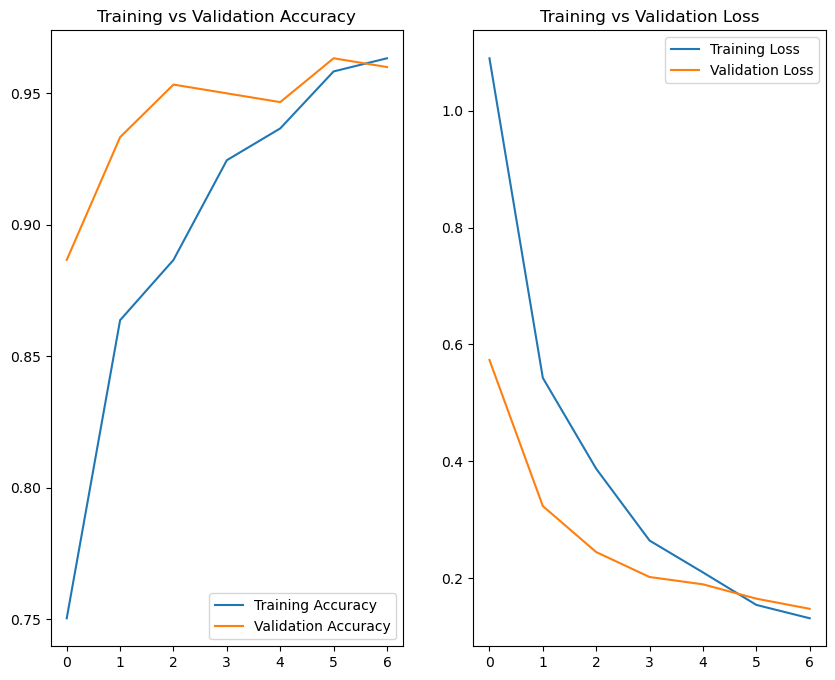

In [33]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots

In [35]:
# model evalution
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 356ms/step - Accuracy: 0.9561 - loss: 0.1469
Test accuracy is0.9533, Test loss is 0.1441


In [37]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)                           

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))                            
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 954ms/step
[[28  0  0  0  0  2  0  0  0  0]
 [ 0 29  1  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  0  1  0]
 [ 1  0  0 29  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 0  0  0  0  0 29  1  0  0  0]
 [ 1  0  1  0  0  0 28  0  0  0]
 [ 0  0  0  0  0  1  0 29  0  0]
 [ 0  0  1  1  0  0  2  0 26  0]
 [ 1  0  0  0  0  0  0  0  0 29]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        30
           1       1.00      0.97      0.98        30
           2       0.91      0.97      0.94        30
           3       0.97      0.97      0.97        30
           4       1.00      1.00      1.00        30
           5       0.91      0.97      0.94        30
           6       0.90      0.93      0.92        30
           7       1.00      0.97      0.98        30
           8       0.96      0.87      0.91        30
           9       1.00      0.97      0.98        30

    accuracy                   

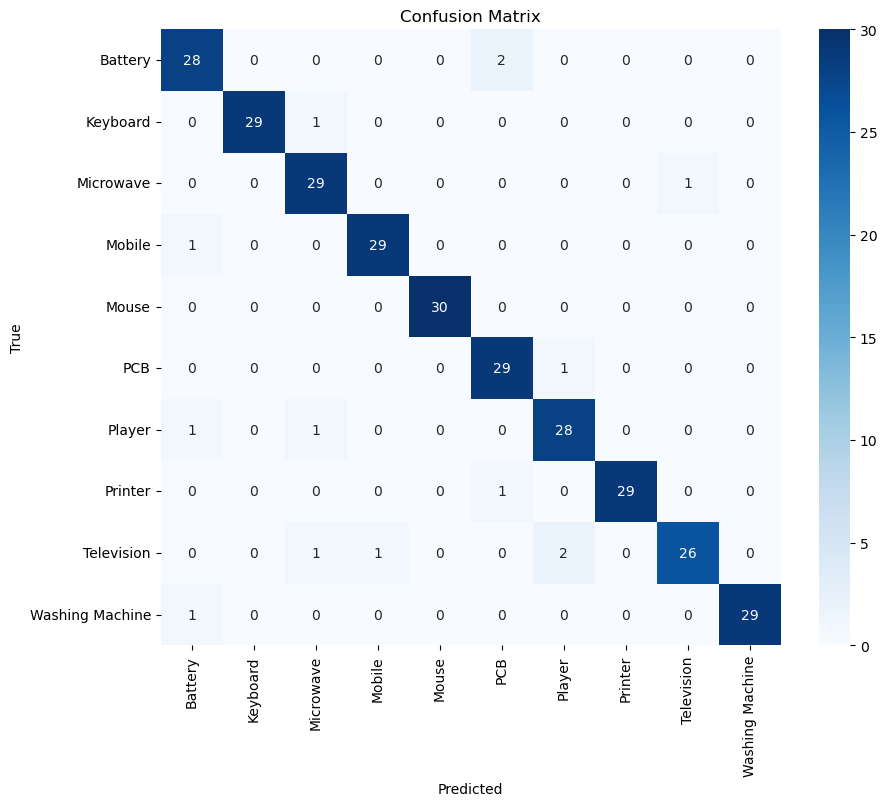

In [39]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


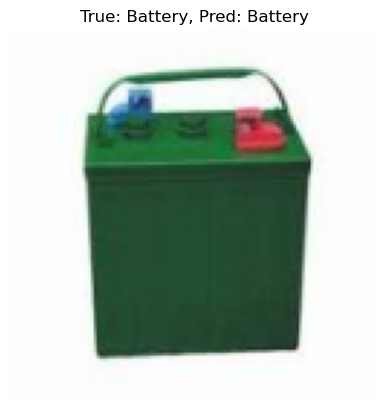

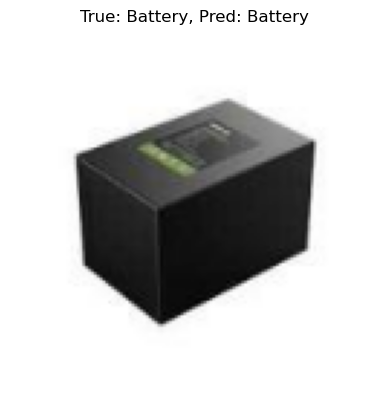

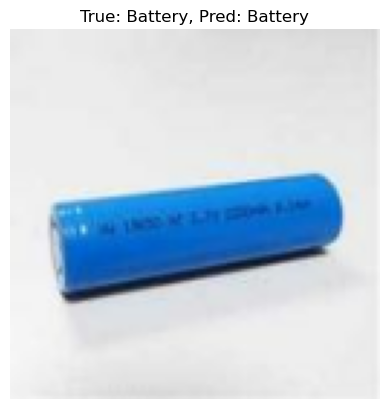

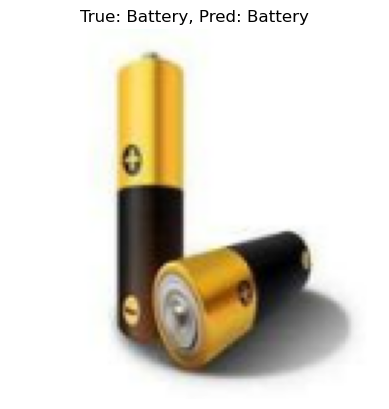

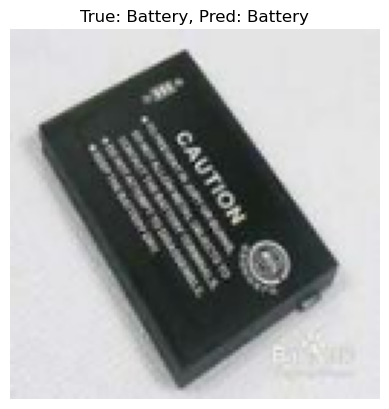

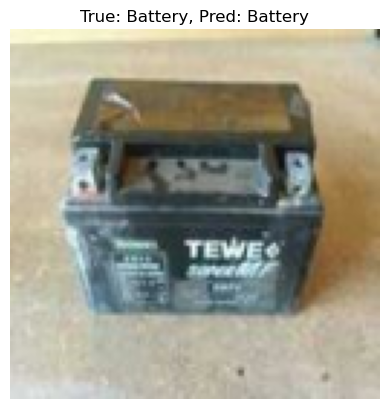

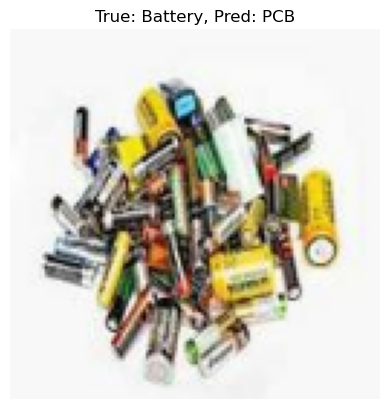

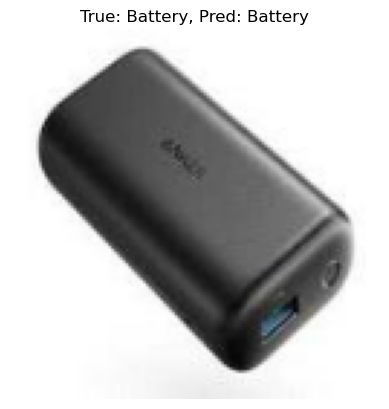

In [41]:
# final testing
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()                                                          # Show image

In [43]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify.keras')

In [45]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')